In [1]:
from src.config import config
import pandas as pd
import os
img_dir = os.path.join(config["DATA_DIR"], "3D_val_npz")
gts_dir = os.path.join(config["DATA_DIR"], "3D_val_gt_interactive_seg")
output_dir = os.path.join(config["RESULTS_DIR"], "simple")

Loaded configuration for machine: nora


In [2]:
# get our and baseline metrics


evalmetrics_df = pd.read_csv(os.path.join(output_dir, "norateam_metrics_2130_cases.csv"))
baselinesmetrics_df = pd.read_csv(os.path.join(config["RESULTS_DIR"], "CVPR25-Baseline-ValidationResults - interactive-seg-coreset.csv"))
nninteractivemetrics_df = pd.read_csv(os.path.join(config["RESULTS_DIR"], "nninteractive_metrics_combined.csv"))
print(len(evalmetrics_df))
print(len(baselinesmetrics_df))
print(len(nninteractivemetrics_df))

2130
2145
2070


In [3]:
# get spacing, shape and has_bbox for each case
import numpy as np
dscs = []
nsds = []
spacings = []
shapes = []
evalmetrics_df["spacing"] = None
evalmetrics_df["spacing"] = evalmetrics_df["spacing"].astype(object)
evalmetrics_df["shape"] = None
evalmetrics_df["shape"] = evalmetrics_df["shape"].astype(object)
evalmetrics_df["has_bbox"] = None
for i, case_filename in enumerate(evalmetrics_df['CaseName']):
    case_filename += ".npz"
    img_filepath = os.path.join(img_dir, case_filename)
    img_data = np.load(img_filepath)
    gt_filepath = os.path.join(gts_dir, case_filename)
    gt_data = np.load(gt_filepath)
    gts = gt_data["gts"]
    spacing = gt_data["spacing"]
    shape = gts.shape
    spacing = np.array(spacing)
    case_name = os.path.splitext(case_filename)[0]
    
    matching_indices = evalmetrics_df[evalmetrics_df['CaseName'] == case_name].index
    for idx in matching_indices:
        evalmetrics_df.at[idx, 'spacing'] = spacing
        evalmetrics_df.at[idx, 'shape'] = shape
        evalmetrics_df.at[idx, 'has_bbox'] = "boxes" in img_data

In [4]:
# add modality
evalmetrics_df['modality'] = evalmetrics_df['CaseName'].str[:2]


In [5]:
# see nb of common cases
common_cases = set(evalmetrics_df["CaseName"]).intersection(set(baselinesmetrics_df["CaseName"]))
print(f"Number of common cases: {len(common_cases)}")
# cases in evalmetrics_df but not in baselinesmetrics_df
missing_cases = set(evalmetrics_df["CaseName"]) - set(baselinesmetrics_df["CaseName"])
print(f"Number of cases in evalmetrics_df but not in baselinesmetrics_df: {len(missing_cases)}")
# cases in baselinesmetrics_df but not in evalmetrics_df
missing_baselines_cases = set(baselinesmetrics_df["CaseName"]) - set(evalmetrics_df["CaseName"])
print(f"Number of cases in baselinesmetrics_df but not in evalmetrics_df: {len(missing_baselines_cases)}")

Number of common cases: 0
Number of cases in evalmetrics_df but not in baselinesmetrics_df: 2130
Number of cases in baselinesmetrics_df but not in evalmetrics_df: 2145


In [6]:
baselinesmetrics_df["CaseName"] = baselinesmetrics_df["CaseName"].str.replace(".npz", "")
nninteractivemetrics_df["CaseName"] = nninteractivemetrics_df["CaseName"].str.replace(".npz", "")
# add "ours_" prefix to columns from evalmetrics_df
evalmetrics_df = evalmetrics_df.rename(columns=lambda x: f"ours_{x}" if x not in ["CaseName", "spacing", "shape", "has_bbox", "modality"] else x)
# add "nninteractive_" prefix to columns from nninteractivemetrics_df
nninteractivemetrics_df = nninteractivemetrics_df.rename(columns=lambda x: f"nninteractive_{x}" if x not in ["CaseName", "spacing", "shape", "has_bbox", "modality"] else x)

In [7]:

# merge baselinesmetrics_df into evalmetrics_df
merged_df = evalmetrics_df.merge(baselinesmetrics_df, on="CaseName", how="left")
# merge nninteractivemetrics_df into merged_df
merged_df = merged_df.merge(nninteractivemetrics_df, on="CaseName", how="left")
print(len(merged_df))
print(merged_df.columns)
# modalities count
modality_counts = merged_df['modality'].value_counts()
print(modality_counts)



2130
Index(['CaseName', 'ours_TotalRunningTime', 'ours_RunningTime_1',
       'ours_RunningTime_2', 'ours_RunningTime_3', 'ours_RunningTime_4',
       'ours_RunningTime_5', 'ours_RunningTime_6', 'ours_DSC_AUC',
       'ours_NSD_AUC',
       ...
       'nninteractive_DSC_5', 'nninteractive_DSC_6', 'nninteractive_NSD_1',
       'nninteractive_NSD_2', 'nninteractive_NSD_3', 'nninteractive_NSD_4',
       'nninteractive_NSD_5', 'nninteractive_NSD_6', 'nninteractive_num_class',
       'nninteractive_runtime_upperbound'],
      dtype='object', length=101)
modality
MR    977
CT    897
US    108
Mi     83
PE     65
Name: count, dtype: int64


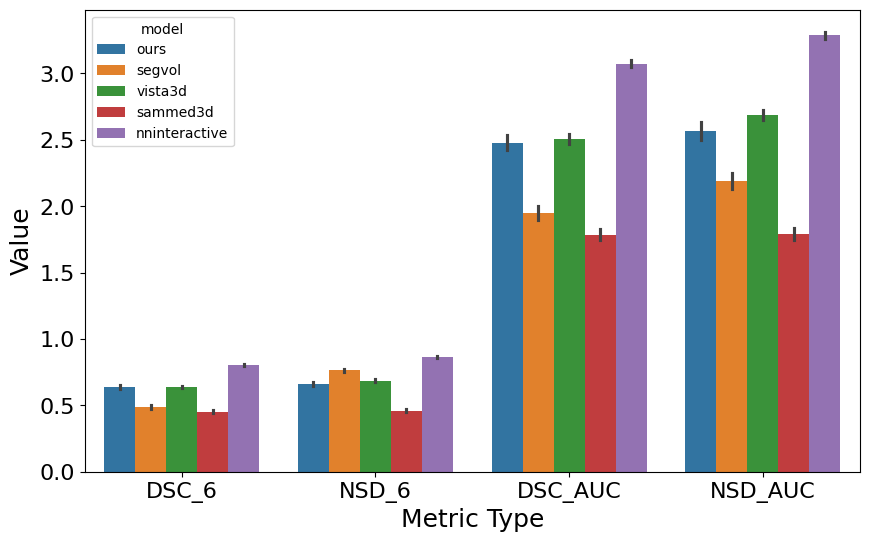

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

metrics_names = ["DSC_6", "NSD_6", "DSC_AUC", "NSD_AUC"]

# Find columns for each metric
metric_cols = []
for metric in metrics_names:
    cols = [col for col in merged_df.columns if metric in col]
    metric_cols.extend(cols)

# Melt data
melted = merged_df.melt(id_vars=['modality', 'has_bbox'], value_vars=metric_cols, 
                       var_name='metric', value_name='value')

# Extract metric type and model name
melted['metric_type'] = melted['metric'].apply(lambda x: next(m for m in metrics_names if m in x))
melted['model'] = melted['metric'].str.replace('_.*', '', regex=True)

# Plot
fontsize = 16
plt.figure(figsize=(10, 6))
sns.barplot(data=melted, x='metric_type', y='value', hue='model')
plt.xlabel('Metric Type', fontsize=fontsize+2)
plt.ylabel('Value', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

In [10]:
model_means = melted.groupby(['metric_type', 'model'])['value'].mean().reset_index()

for metric in metrics_names:
    # Get data for this metric type
    metric_data = model_means[model_means['metric_type'] == metric]
    
    # Sort by value in descending order (assuming higher is better)
    # If lower is better for some metrics, change to ascending=True
    metric_ranked = metric_data.sort_values('value', ascending=False).reset_index(drop=True)
    metric_ranked['rank'] = range(1, len(metric_ranked) + 1)
    
    # Find rank of "ours" method
    ours_rank = metric_ranked[metric_ranked['model'] == 'ours']['rank']
    
    if not ours_rank.empty:
        rank = ours_rank.iloc[0]
        total_models = len(metric_ranked)
        ours_value = metric_ranked[metric_ranked['model'] == 'ours']['value'].iloc[0]
        print(f"{metric}: Rank {rank} out of {total_models} models (value: {ours_value:.4f})")
    else:
        print(f"{metric}: 'ours' method not found")
print("\nDetailed rankings for each metric:")
print("=" * 50)

for metric in metrics_names:
    print(f"\n{metric}:")
    metric_data = model_means[model_means['metric_type'] == metric]
    metric_ranked = metric_data.sort_values('value', ascending=False).reset_index(drop=True)
    
    for idx, row in metric_ranked.iterrows():
        marker = " ← OURS" if row['model'] == 'ours' else ""
        print(f"  {idx+1}. {row['model']}: {row['value']:.4f}{marker}")

DSC_6: Rank 3 out of 5 models (value: 0.6386)
NSD_6: Rank 4 out of 5 models (value: 0.6614)
DSC_AUC: Rank 3 out of 5 models (value: 2.4800)
NSD_AUC: Rank 3 out of 5 models (value: 2.5671)

Detailed rankings for each metric:

DSC_6:
  1. nninteractive: 0.8043
  2. vista3d: 0.6393
  3. ours: 0.6386 ← OURS
  4. segvol: 0.4870
  5. sammed3d: 0.4525

NSD_6:
  1. nninteractive: 0.8648
  2. segvol: 0.7645
  3. vista3d: 0.6867
  4. ours: 0.6614 ← OURS
  5. sammed3d: 0.4600

DSC_AUC:
  1. nninteractive: 3.0732
  2. vista3d: 2.5054
  3. ours: 2.4800 ← OURS
  4. segvol: 1.9478
  5. sammed3d: 1.7839

NSD_AUC:
  1. nninteractive: 3.2883
  2. vista3d: 2.6878
  3. ours: 2.5671 ← OURS
  4. segvol: 2.1892
  5. sammed3d: 1.7900


Rankings for 'ours' method (DSC_AUC by modality):
--------------------------------------------------
CT: Rank 2 out of 5 models (value: 3.2198)
MR: Rank 3 out of 5 models (value: 1.5945)
Mi: Rank 2 out of 5 models (value: 2.9476)
PE: Rank 1 out of 5 models (value: 3.2278)
US: Rank 1 out of 5 models (value: 3.5364)

Detailed rankings by modality:

CT:
  1. nninteractive: 3.4385
  2. ours: 3.2198 ← OURS
  3. segvol: 2.9075
  4. vista3d: 2.8100
  5. sammed3d: 2.2517

MR:
  1. nninteractive: 2.6975
  2. vista3d: 2.2901
  3. ours: 1.5945 ← OURS
  4. sammed3d: 1.5191
  5. segvol: 1.1131

Mi:
  1. nninteractive: 3.3642
  2. ours: 2.9476 ← OURS
  3. segvol: 2.0355
  4. vista3d: 1.7183
  5. sammed3d: 0.3042

PE:
  1. ours: 3.2278 ← OURS
  2. nninteractive: 3.2056
  3. segvol: 2.8420
  4. vista3d: 2.1870
  5. sammed3d: 2.0954

US:
  1. ours: 3.5364 ← OURS
  2. nninteractive: 3.3494
  3. vista3d: 2.6141
  4. sammed3d: 1.3466
  5. segvol: 1.2210

Overall ranking (averaged across modalities):
  1. 

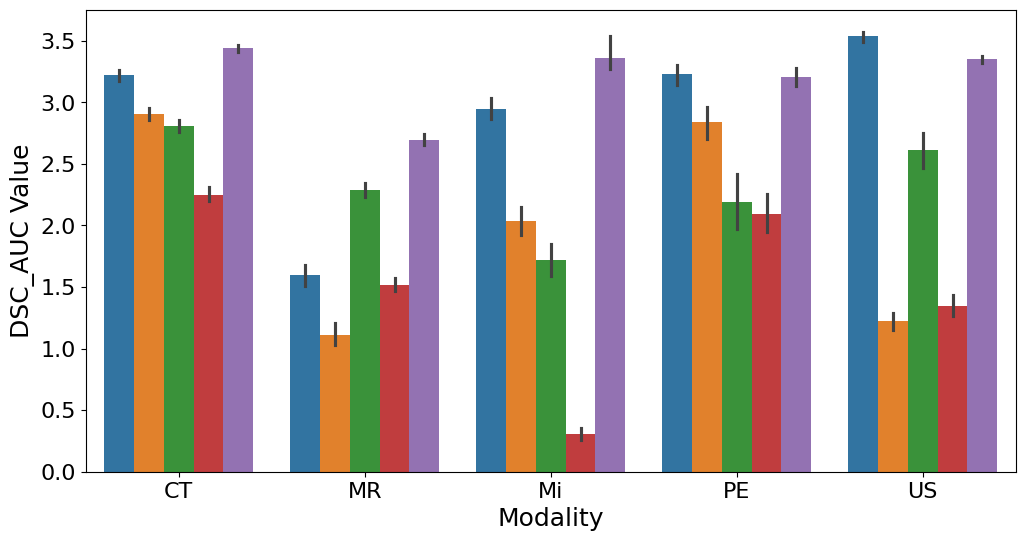

<Figure size 640x480 with 0 Axes>

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


metric_name_here = "DSC_AUC"
# Filter for DSC_AUC metric only for ranking calculation
dsc_auc_melted = melted[melted['metric_type'] == metric_name_here]

# Calculate mean values for each model and modality for DSC_AUC metric
model_means_dsc = dsc_auc_melted.groupby(['modality', 'model'])['value'].mean().reset_index()

# Print rankings for "ours" method for DSC_AUC by modality
print("Rankings for 'ours' method ("+metric_name_here+" by modality):")
print("-" * 50)

# Get unique modalities
modalities = dsc_auc_melted['modality'].unique()

for modality in modalities:
    # Get data for this modality
    modality_data = model_means_dsc[model_means_dsc['modality'] == modality]
    
    # Sort by value in descending order (assuming higher is better)
    modality_ranked = modality_data.sort_values('value', ascending=False).reset_index(drop=True)
    modality_ranked['rank'] = range(1, len(modality_ranked) + 1)
    
    # Find rank of "ours" method
    ours_rank = modality_ranked[modality_ranked['model'] == 'ours']['rank']
    
    if not ours_rank.empty:
        rank = ours_rank.iloc[0]
        total_models = len(modality_ranked)
        ours_value = modality_ranked[modality_ranked['model'] == 'ours']['value'].iloc[0]
        print(f"{modality}: Rank {rank} out of {total_models} models (value: {ours_value:.4f})")
    else:
        print(f"{modality}: 'ours' method not found")

print("\nDetailed rankings by modality:")
print("=" * 45)

for modality in modalities:
    print(f"\n{modality}:")
    modality_data = model_means_dsc[model_means_dsc['modality'] == modality]
    modality_ranked = modality_data.sort_values('value', ascending=False).reset_index(drop=True)
    
    for idx, row in modality_ranked.iterrows():
        marker = " ← OURS" if row['model'] == 'ours' else ""
        print(f"  {idx+1}. {row['model']}: {row['value']:.4f}{marker}")

# Also show overall ranking across all modalities
print("\nOverall ranking (averaged across modalities):")
print("=" * 50)

overall_means = dsc_auc_melted.groupby('model')['value'].mean().reset_index()
overall_ranked = overall_means.sort_values('value', ascending=False).reset_index(drop=True)

for idx, row in overall_ranked.iterrows():
    marker = " ← OURS" if row['model'] == 'ours' else ""
    print(f"  {idx+1}. {row['model']}: {row['value']:.4f}{marker}")

# Filter for DSC_AUC metric only
dsc_auc_data = melted[melted['metric_type'] == metric_name_here]

# Plot DSC_AUC by modality and model
plt.figure(figsize=(12, 6))
sns.barplot(data=dsc_auc_data, x='modality', y='value', hue='model', legend=False)
#plt.title(metric_name_here +' Performance by Modality and Model')

plt.xlabel('Modality', fontsize=fontsize+2)
plt.ylabel(metric_name_here + ' Value', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()
plt.tight_layout()

plt.show()

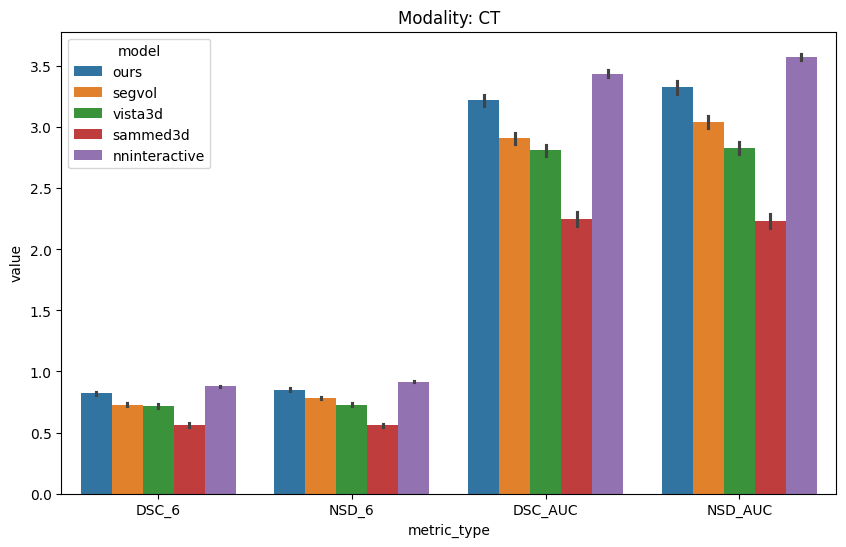

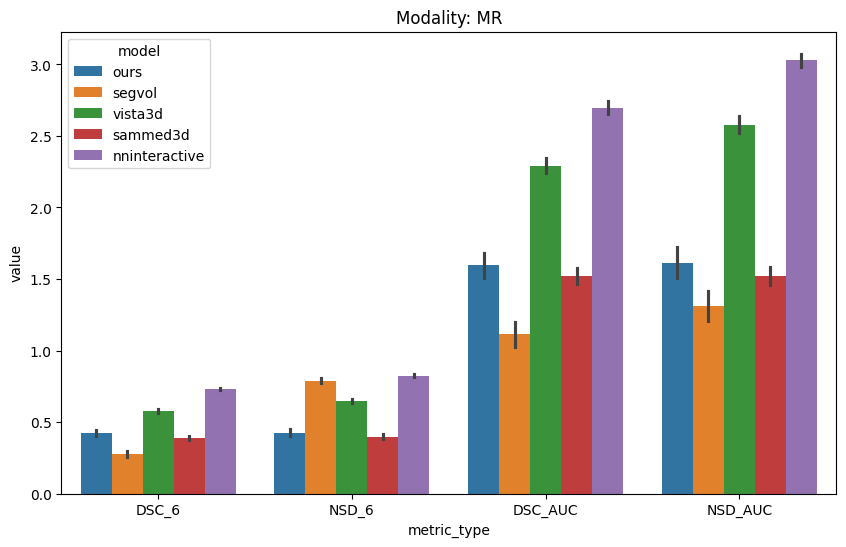

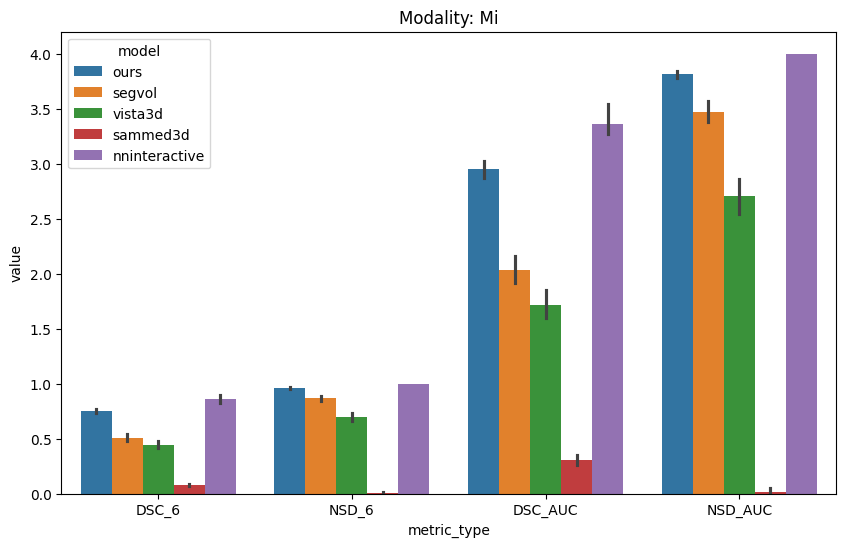

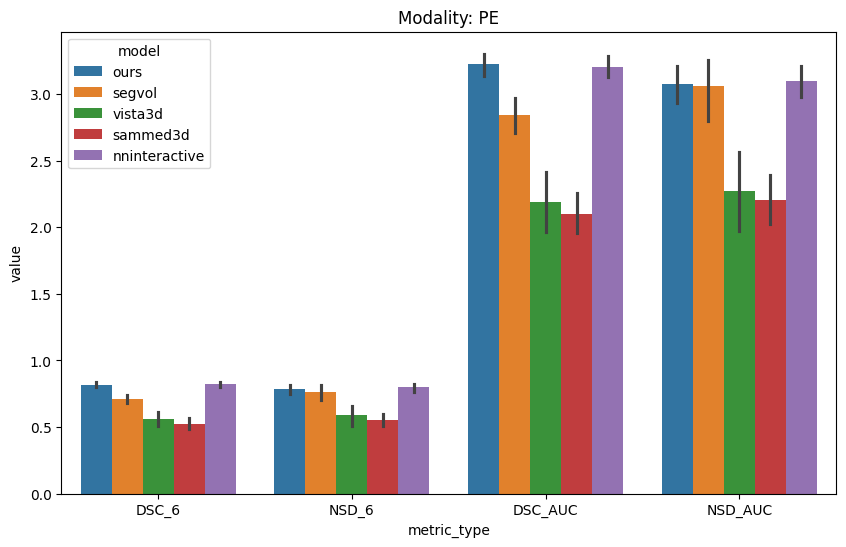

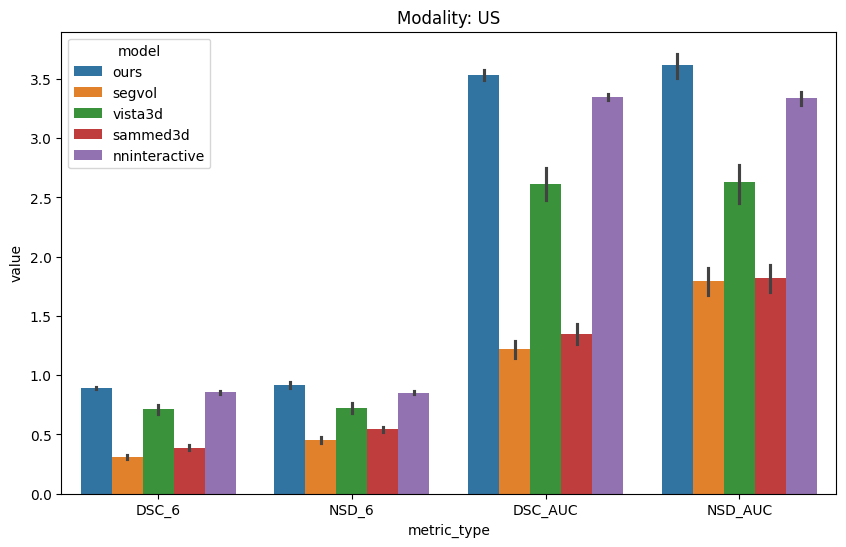

In [11]:
# Plot one per modality
for modality in merged_df['modality'].unique():
    plt.figure(figsize=(10, 6))
    data = melted[melted['modality'] == modality]
    sns.barplot(data=data, x='metric_type', y='value', hue='model')
    plt.title(f'Modality: {modality}')
    plt.show()

Plotting for has_bbox: True


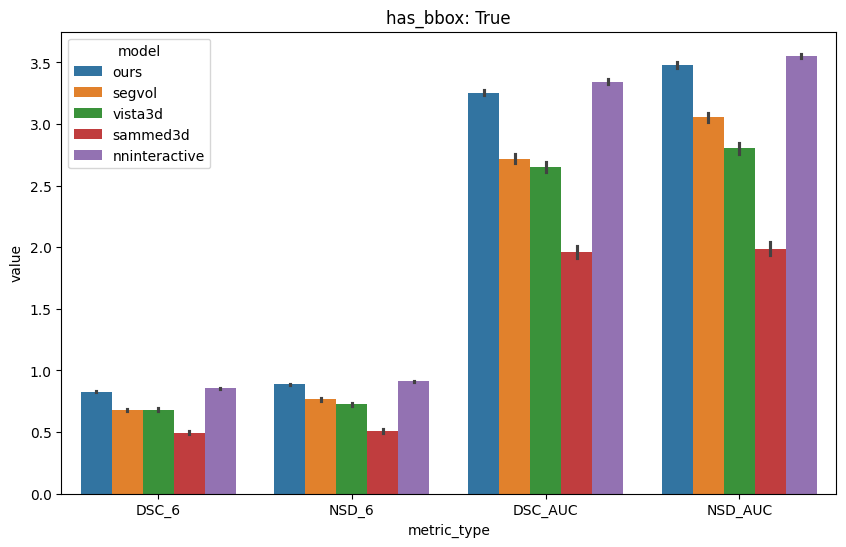

Plotting for has_bbox: False


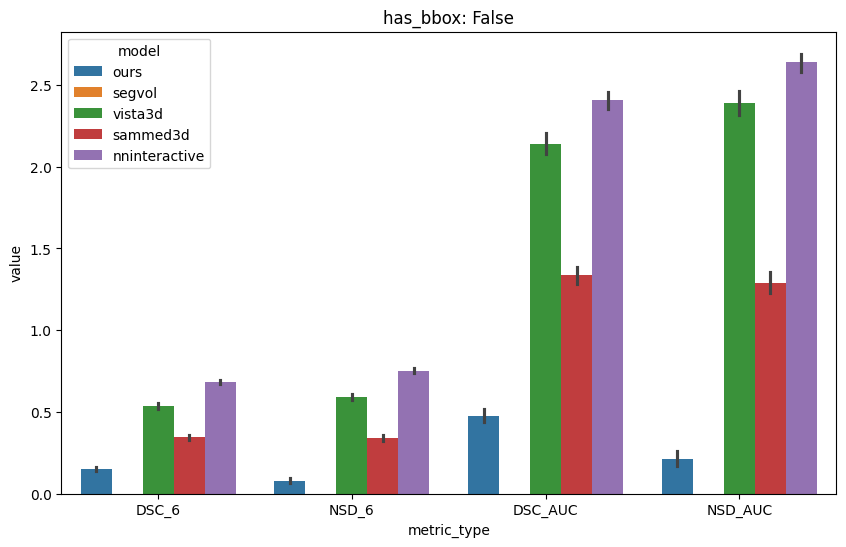

In [21]:
# Plot one per modality
for has_bbox in melted['has_bbox'].unique():
    print(f"Plotting for has_bbox: {has_bbox}")
    plt.figure(figsize=(10, 6))
    data = melted[melted['has_bbox'] == has_bbox]
    sns.barplot(data=data, x='metric_type', y='value', hue='model')
    plt.title(f'has_bbox: {has_bbox}')
    plt.show()

Plotting for has_bbox: True


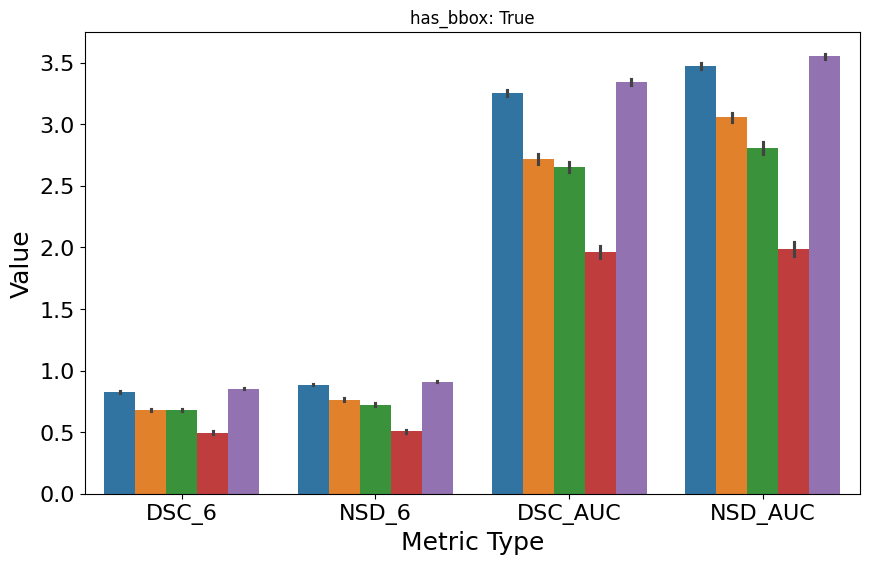

Plotting for has_bbox: False


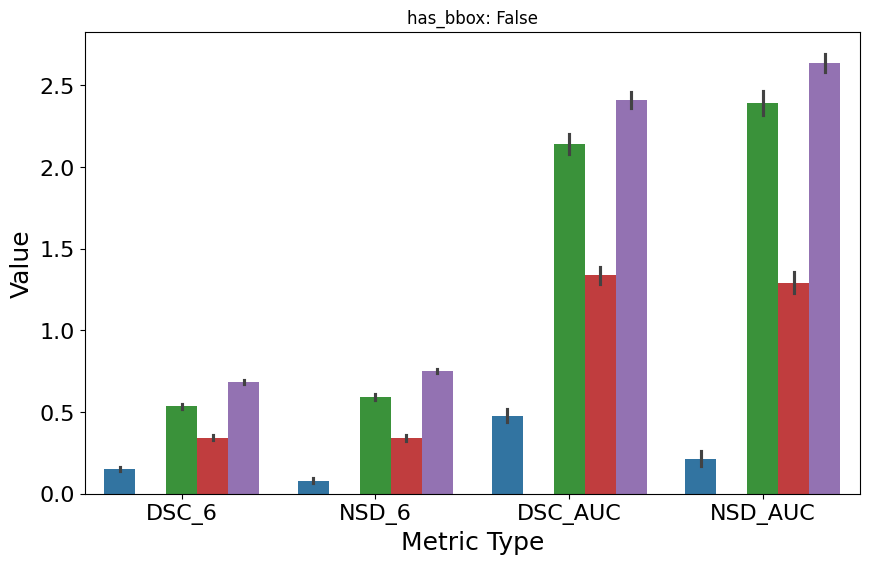


Rankings for 'ours' method by has_bbox and metric:

has_bbox: True
------------------------------
  DSC_6: Rank 2 out of 5 models (value: 0.8276)
  NSD_6: Rank 2 out of 5 models (value: 0.8863)
  DSC_AUC: Rank 2 out of 5 models (value: 3.2550)
  NSD_AUC: Rank 2 out of 5 models (value: 3.4774)

has_bbox: False
------------------------------
  DSC_6: Rank 4 out of 5 models (value: 0.1499)
  NSD_6: Rank 4 out of 5 models (value: 0.0799)
  DSC_AUC: Rank 4 out of 5 models (value: 0.4759)
  NSD_AUC: Rank 4 out of 5 models (value: 0.2132)


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

metrics_names = ["DSC_6", "NSD_6", "DSC_AUC", "NSD_AUC"]

# Find columns for each metric
metric_cols = []
for metric in metrics_names:
    cols = [col for col in merged_df.columns if metric in col]
    metric_cols.extend(cols)

# Melt data
melted = merged_df.melt(id_vars=['modality', 'has_bbox'], value_vars=metric_cols, 
                       var_name='metric', value_name='value')

# Extract metric type and model name
melted['metric_type'] = melted['metric'].apply(lambda x: next(m for m in metrics_names if m in x))
melted['model'] = melted['metric'].str.replace('_.*', '', regex=True)

# Plot by has_bbox for all metrics (all modalities mixed)
for has_bbox in melted['has_bbox'].unique():
    print(f"Plotting for has_bbox: {has_bbox}")
    plt.figure(figsize=(10, 6))
    data = melted[melted['has_bbox'] == has_bbox]
    sns.barplot(data=data, x='metric_type', y='value', hue='model', legend=False)
    plt.xlabel('Metric Type', fontsize=fontsize+2)
    plt.ylabel('Value', fontsize=fontsize+2)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.title(f'has_bbox: {has_bbox}')
    plt.show()

# Print rankings for "ours" method for each metric by has_bbox
print("\nRankings for 'ours' method by has_bbox and metric:")
print("=" * 55)

for has_bbox in melted['has_bbox'].unique():
    print(f"\nhas_bbox: {has_bbox}")
    print("-" * 30)
    
    bbox_data = melted[melted['has_bbox'] == has_bbox]
    
    for metric in metrics_names:
        # Get data for this metric and has_bbox combination
        metric_bbox_data = bbox_data[bbox_data['metric_type'] == metric]
        
        if not metric_bbox_data.empty:
            # Calculate mean values for each model
            model_means = metric_bbox_data.groupby('model')['value'].mean().reset_index()
            
            # Sort by value in descending order (assuming higher is better)
            metric_ranked = model_means.sort_values('value', ascending=False).reset_index(drop=True)
            metric_ranked['rank'] = range(1, len(metric_ranked) + 1)
            
            # Find rank of "ours" method
            ours_rank = metric_ranked[metric_ranked['model'] == 'ours']['rank']
            
            if not ours_rank.empty:
                rank = ours_rank.iloc[0]
                total_models = len(metric_ranked)
                ours_value = metric_ranked[metric_ranked['model'] == 'ours']['value'].iloc[0]
                print(f"  {metric}: Rank {rank} out of {total_models} models (value: {ours_value:.4f})")
            else:
                print(f"  {metric}: 'ours' method not found")
        else:
            print(f"  {metric}: No data available")

# Filter for DSC_AUC metric only
dsc_auc_data = melted[melted['metric_type'] == 'DSC_AUC']

has_bbox      False       True 
modality                       
CT         2.675585   97.324415
MR        58.341863   41.658137
Mi         0.000000  100.000000
PE         0.000000  100.000000
US         0.000000  100.000000


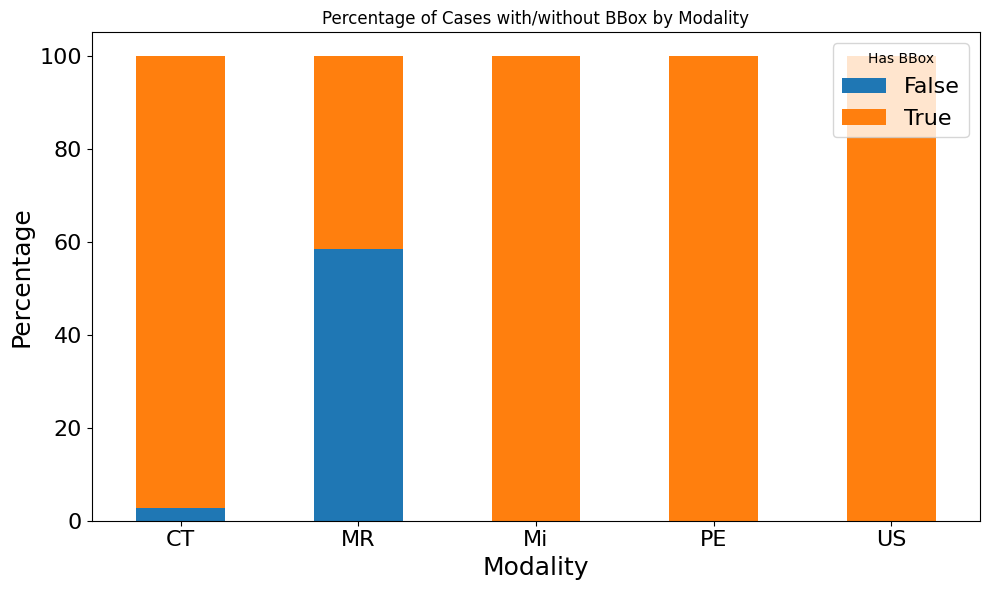

In [45]:
# Calculate percentages for each modality
bbox_percentages = evalmetrics_df.groupby('modality')['has_bbox'].value_counts(normalize=True).unstack().fillna(0) * 100

# Display the percentages
print(bbox_percentages)

# Plot as a stacked bar chart
plt.figure(figsize=(10, 6))
bbox_percentages.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Percentage of Cases with/without BBox by Modality')
plt.xlabel('Modality', fontsize=fontsize+2)
plt.ylabel('Percentage', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize, rotation=0)
plt.yticks(fontsize=fontsize)
plt.legend(title='Has BBox', fontsize=fontsize)

plt.tight_layout()
plt.show()

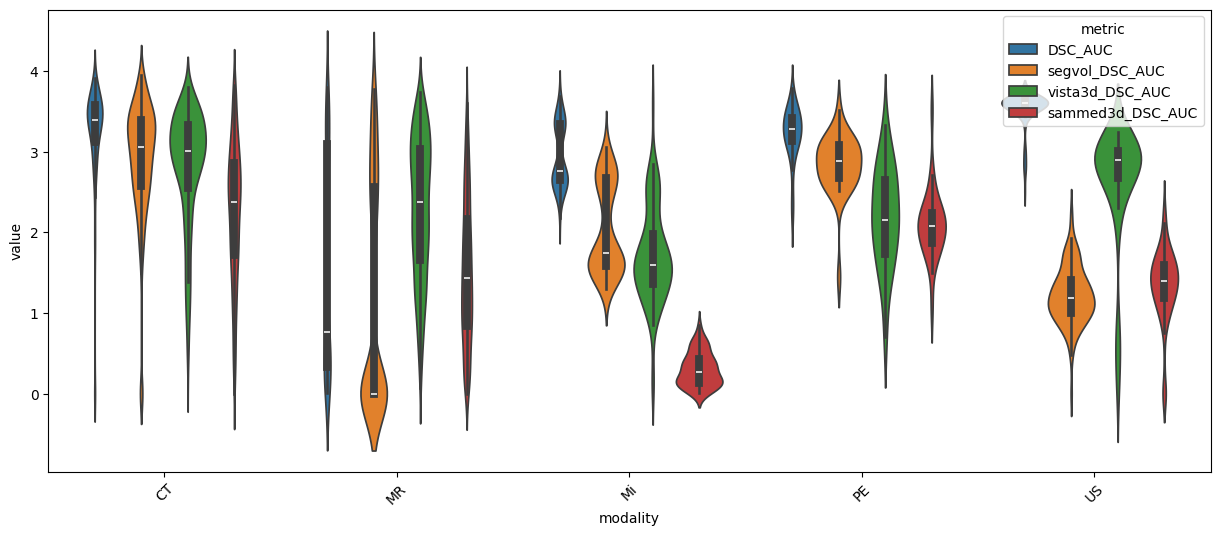

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Find DSC_AUC columns
dsc_cols = [col for col in merged_df.columns if 'DSC_AUC' in col]

# Melt data
melted = merged_df.melt(id_vars=['modality'], value_vars=dsc_cols, 
                       var_name='metric', value_name='value')

# Plot
plt.figure(figsize=(15, 6))
sns.violinplot(data=melted, x='modality', y='value', hue='metric')
plt.xticks(rotation=45)
plt.show()

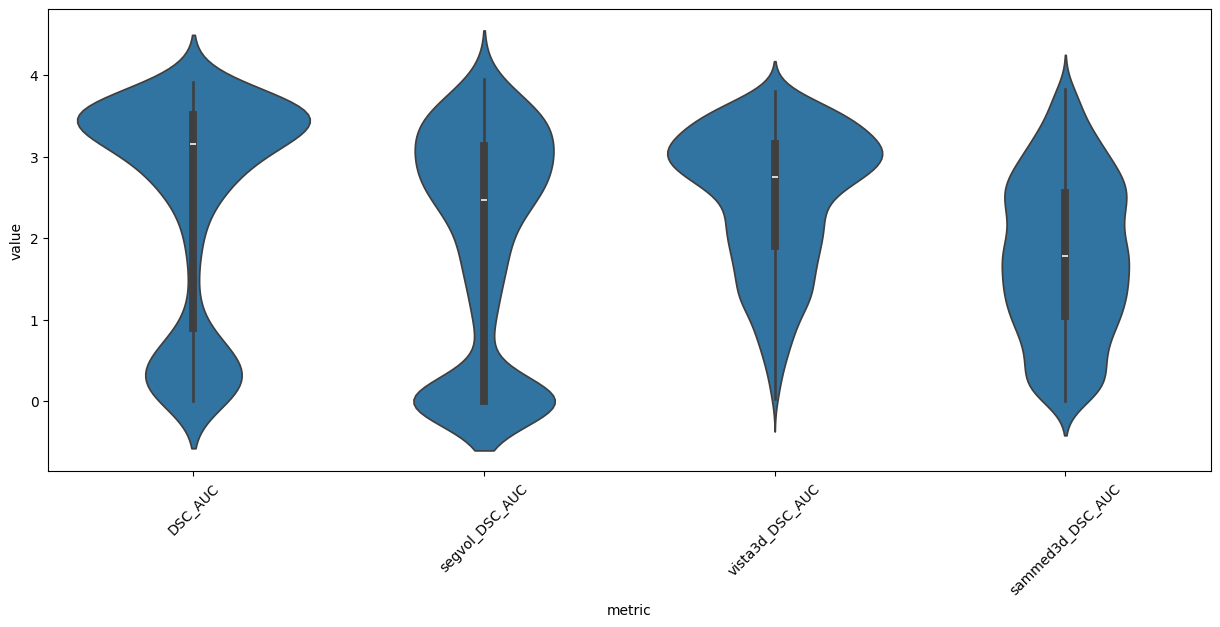

In [23]:

# Plot
plt.figure(figsize=(15, 6))
sns.violinplot(data=melted, x='metric', y='value')
plt.xticks(rotation=45)
plt.show()
